<a href="https://colab.research.google.com/github/sergiomora03/AdvancedTopicsAnalytics/blob/main/exercises/E1-UsedVehiclePricePredictionDeployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# E1 - Model Deployment in Used Vehicle Price Prediction

## Introduction

- 1.2 Million listings scraped from TrueCar.com - Price, Mileage, Make, Model dataset from Kaggle: [data](https://www.kaggle.com/jpayne/852k-used-car-listings)
- Each observation represents the price of an used car

In [ ]:
%matplotlib inline
import pandas as pd
import ssl
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
import joblib


- Se genera la carga de los datos

In [ ]:
ssl._create_default_https_context = ssl._create_unverified_context
data = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTrain_carListings.zip')

## Revision Datos

- En las siguientes lineas se realiza la revisión de los datos, donde se comprueba si hay datos nulos, si hay datos duplicados y se realiza el ajuste, eliminando los datos que se encuentran duplicados
- Se realiza la copia de la base en un data frame, para poder trabajar con este.

In [ ]:
df = data.copy()


In [ ]:
df.head()

,Price,Year,Mileage,State,Make,Model
0,21490,2014,31909,20,27,305
1,21250,2016,25741,17,6,83
2,20925,2016,24633,40,14,400
3,14500,2012,84026,36,17,248
4,32488,2013,22816,42,17,489


In [ ]:
df.shape

(500000, 6)

In [ ]:
##Check features with nan value
df.isnull().sum()

Price      0
Year       0
Mileage    0
State      0
Make       0
Model      0
dtype: int64

In [ ]:
df.Mileage.min()

np.int64(5)

In [ ]:
df.Mileage.max()

np.int64(2457832)

## Encoding

- Se codifican las categorias para que sea mucho más fácil trabajar con estas, ya que al dumificar los valores se generan muchas columnas que hacen mucho más amplio, esto se probó y los resultados pueden ser relativamente mejores cuando se codifica.

In [ ]:
ordinal_encoder = OrdinalEncoder()
df[['State', 'Make', 'Model']] = ordinal_encoder.fit_transform(df[['State', 'Make', 'Model']])

# Guardar el codificador ordinal
joblib.dump(ordinal_encoder, 'ordinal_encoder.pkl')


X = df[['Year', 'Mileage', 'State', 'Make', 'Model']]
y = df['Price']


- Se validaron los valores duplicados y se revisan cuales fueron, una vez codificados.

In [ ]:
df.duplicated().sum()
duplicados = df.duplicated()
duplicados_valores = df[duplicados]
print(duplicados_valores)

        Price  Year  Mileage  State  Make  Model
37781   24865  2018       10     44    10    233
40335   16488  2017       15      9    35    123
45362   35780  2017       10     44    10    438
53757   15988  2017       15      9    35    123
58577   16995  2017       15      9    35    123
...       ...   ...      ...    ...   ...    ...
490356  35882  2017        5      4    32    326
493629  49410  2018       10     44    10    191
496681  47999  2017       99     38     2    498
498068  31995  2016       11      9    24    434
498252  26285  2017        5     14    13     67

[220 rows x 6 columns]


- Se elimnaron los valores duplicados y posteriormente se revisa cómo queda la base en cantidad de datos.

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.shape

(499780, 6)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 499780 entries, 0 to 499999
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Price    499780 non-null  int64  
 1   Year     499780 non-null  int64  
 2   Mileage  499780 non-null  int64  
 3   State    499780 non-null  float64
 4   Make     499780 non-null  float64
 5   Model    499780 non-null  float64
dtypes: float64(3), int64(3)
memory usage: 26.7 MB


In [ ]:
df.columns

Index(['Price', 'Year', 'Mileage', 'State', 'Make', 'Model'], dtype='object')

In [ ]:
df.loc[261451]

Price      53291
Year        2016
Mileage    22066
State         43
Make          12
Model        416
Name: 261451, dtype: int64

In [ ]:
df['Price'].value_counts()


Price
14995    2868
13995    2762
9995     2695
12995    2679
15995    2541
         ... 
31741       1
58060       1
7158        1
26065       1
63973       1
Name: count, Length: 38222, dtype: int64

## Entrenamiento

- Se gera la división de la base en train y test en 80%, 20%

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



- Nota: Esta linea podría ser ajustada posteriormente, pero dado que se hicieron diferentes pruebas de modelo y codificación, se dejó en el momento, por practicidad,

In [ ]:
X_train_encoded = X_train.copy()

X_test_encoded = X_test.copy()


# Exercise P0.1 (50%)

Develop a machine learning model that predicts the price of the of car using as an input ['Year', 'Mileage', 'State', 'Make', 'Model']

#### Evaluation:
- 25% - Performance of the models using a manually implemented K-Fold (K=10) cross-validation
- 25% - Notebook explaining the process for selecting the best model. You must specify how the calibration of each of the parameters is done and how these change the performance of the model. It is expected that a clear comparison will be made of all implemented models.. Present the most relevant conslusions about the whole process.


## Implementación de modelos
Para los modelos se realizaron 3 modelos diferentes, Regresion Lineal, Random Forest Y XGBoost

## modelo Regresion Linear

La regresion lineal se ejecuta con 10 Folds, haciendo la particion 10 veces de los datos, para poder realizar la prediccion de estos

In [ ]:
# Definir el número de folds
k = 10

# Crear una lista para almacenar los resultados de evaluación
rmse_list = []
mae_list = []

# Obtener los índices de los datos
indices = np.arange(len(X_train_encoded))

# Mezclar los índices aleatoriamente
np.random.shuffle(indices)

# Dividir los datos en K folds
fold_size = len(X_train_encoded) // k
folds = [indices[i:i+fold_size] for i in range(0, len(X_train_encoded), fold_size)]


model = LinearRegression()

# Realizar el K-Fold Cross Validation
for i in range(k):
    # Obtener los índices de entrenamiento y prueba para el fold actual
    test_indices = folds[i]
    train_indices = np.concatenate(folds[:i] + folds[i+1:])

    X_train_fold, X_test_fold = X_train_encoded.iloc[train_indices], X_train_encoded.iloc[test_indices]
    y_train_fold, y_test_fold = y_train.iloc[train_indices], y_train.iloc[test_indices]

    # Entrenar el modelo
    model.fit(X_train_fold, y_train_fold)

    # Predecir
    y_pred_fold = model.predict(X_test_fold)

    # Calcular métricas
    rmse_fold = np.sqrt(mean_squared_error(y_test_fold, y_pred_fold))
    mae_fold = mean_absolute_error(y_test_fold, y_pred_fold)

    # Almacenar métricas
    rmse_list.append(rmse_fold)
    mae_list.append(mae_fold)

# Calcular métricas promedio
mean_rmse = np.mean(rmse_list)
mean_mae = np.mean(mae_list)



print(f'Average Root Mean Squared Error (RMSE): {mean_rmse}')
print(f'Average Mean Absolute Error (MAE): {mean_mae}')

Average Root Mean Squared Error (RMSE): 8926.45783878061
Average Mean Absolute Error (MAE): 6844.976931049464


## Modelo RF

Se aplica la misma estructura que en la regresion lineal, pero esta vez para el modelo de Random Forest.  Se tiene en cuenta los parameteos de número de estimadores, profundidad, random state y jobs.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
import numpy as np

# Inicializar el modelo
model_rf = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)

# Definir el número de folds
k = 10

# Crear una lista para almacenar los resultados de evaluación
rmse_list = []
mae_list = []

# Obtener los índices de los datos
indices = np.arange(len(X_train_encoded))

# Mezclar los índices aleatoriamente
np.random.shuffle(indices)

# Dividir los datos en K folds
fold_size = len(X_train_encoded) // k
folds = [indices[i:i+fold_size] for i in range(0, len(X_train_encoded), fold_size)]

# Listas para almacenar las métricas de cada pliegue
rmse_list = []
mae_list = []

# Realizar K-Fold Cross-Validation
for i in range(k):
    # Obtener los índices de entrenamiento y prueba para el fold actual
    test_index = folds[i]
    train_index = np.concatenate(folds[:i] + folds[i+1:])
    X_train_fold, X_test_fold = X_train_encoded.iloc[train_index], X_train_encoded.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Entrenar el modelo
    model_rf.fit(X_train_fold, y_train_fold)

    # Predecir
    y_pred_fold = model_rf.predict(X_test_fold)

    # Calcular métricas
    rmse_fold = np.sqrt(mean_squared_error(y_test_fold, y_pred_fold))
    mae_fold = mean_absolute_error(y_test_fold, y_pred_fold)

    # Almacenar métricas
    rmse_list.append(rmse_fold)
    mae_list.append(mae_fold)

# Calcular métricas promedio
mean_rmse = np.mean(rmse_list)
mean_mae = np.mean(mae_list)

print(f'Average Root Mean Squared Error (RMSE): {mean_rmse}')
print(f'Average Mean Absolute Error (MAE): {mean_mae}')

Average Root Mean Squared Error (RMSE): 4681.130284507001
Average Mean Absolute Error (MAE): 3217.069183769096


## Modelo XGboost

- Se genera el mismo ejercicio que los modelos anteriores, en el caso del XGBoost, se tiene en cuenta los parameteos de número de estimadores, profundidad, random state y jobs.

In [ ]:
# Inicializar el modelo XGBoost
model_xgb = XGBRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)

# Definir el número de folds
k = 10

# Crear una lista para almacenar los resultados de evaluación
rmse_list = []
mae_list = []

# Obtener los índices de los datos
indices = np.arange(len(X_train_encoded))

# Mezclar los índices aleatoriamente
np.random.shuffle(indices)

# Dividir los datos en K folds
fold_size = len(X_train_encoded) // k
folds = [indices[i:i+fold_size] for i in range(0, len(X_train_encoded), fold_size)]

# Listas para almacenar las métricas de cada pliegue
rmse_list = []
mae_list = []

# Realizar K-Fold Cross-Validation
for i in range(k):
    # Obtener los índices de entrenamiento y prueba para el fold actual
    test_index = folds[i]
    train_index = np.concatenate(folds[:i] + folds[i+1:])

    X_train_fold, X_test_fold = X_train_encoded.iloc[train_index], X_train_encoded.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Entrenar el modelo
    model_xgb.fit(X_train_fold, y_train_fold)

    # Predecir
    y_pred_fold = model_xgb.predict(X_test_fold)

    # Calcular métricas
    rmse_fold = np.sqrt(mean_squared_error(y_test_fold, y_pred_fold))
    mae_fold = mean_absolute_error(y_test_fold, y_pred_fold)

    # Almacenar métricas
    rmse_list.append(rmse_fold)
    mae_list.append(mae_fold)

# Calcular métricas promedio
mean_rmse = np.mean(rmse_list)
mean_mae = np.mean(mae_list)

print(f'Average Root Mean Squared Error (RMSE): {mean_rmse}')
print(f'Average Mean Absolute Error (MAE): {mean_mae}')

El modelo que se escoge trabajar es el modelo del XGboost, dado que trae mejores resultados en comparación con los otros dos modelos, con un menor RMSE, que en este caso da cercano a los 4K. Que para efectos del modelo aunque es alto, puede ser un mejor valor que tener gastos superiores a 5K.

## almacenamiento modelos

- por medio de la librería de joblib se guardan los modelos en un archivo.pkl

In [ ]:
joblib.dump(model, 'model.pkl')

['model.pkl']

In [ ]:
joblib.dump(model_rf, 'model_rf.pkl')

['model_rf.pkl']

In [ ]:
joblib.dump(model_rf, 'model_xgb.pkl')

In [ ]:
predict = model.predict(X_test_encoded)

In [ ]:
predict

array([27816.23136759, 25134.15756744, 26107.44928197, ...,
       21841.16998523,  6859.95420534, 28044.29995154])

In [ ]:
X_train_encoded.head(1)

,Year,Mileage,State,Make,Model
269056,2014,13413,8,35,90


In [ ]:
input_data = pd.DataFrame([[2023, 30000, 25, 1, 104]], columns=['Year', 'Mileage', 'State', 'Make', 'Model'])

In [ ]:
model.predict(input_data)

array([31582.399151])

In [ ]:
import pickle as pk

In [ ]:
pk.dump(model,open('model.pkl','wb'))

# Exercise P0.2 (50%)

Create an API of the model.

Example:
![](https://github.com/sergiomora03/AdvancedTopicsAnalytics/blob/main/notebooks/img/img015.PNG?raw=true)

#### Evaluation:
- 40% - API hosted on a cloud service
- 10% - Show screenshots of the model doing the predictions on the local machine


### API

In [ ]:
from flask import Flask
from flask_restx import Api, Resource, fields
import joblib

In [ ]:
app = Flask(__name__)

api = Api(
    app,
    version='1.0',
    title='Car Price Prediction API',
    description='Car Price Prediction API')

ns = api.namespace('predict',
     description='Price Prediction')

parser = api.parser()

parser.add_argument(
    'URL',
    type=str,
    required=True,
    help='URL to be analyzed',
    location='args')

resource_fields = api.model('Resource', {
    'result': fields.String,
})

In [ ]:
from flask import Flask, request
from flask_restx import Api, Resource, fields
import joblib

# Load the trained models
model = joblib.load('despliegue/model.pkl')
model_rf = joblib.load('despliegue/model_rf.pkl')

# Create the Flask app
app = Flask(__name__)
api = Api(app, version='1.0', title='Car Price Prediction API', description='API for predicting car prices')

# Define the input and output fields
precio_carro = api.model('PrecioCarro', {
    'Year': fields.Integer(required=True, description='Year of the car'),
    'Mileage': fields.Integer(required=True, description='Mileage of the car'),
    'State': fields.String(required=True, description='State of the car'),
    'Make': fields.String(required=True, description='Make of the car'),
    'Model': fields.String(required=True, description='Model of the car')
})

prediction = api.model('Prediction', {
    'Price': fields.Float(description='Predicted price of the car')
})

# Define the API endpoint
@api.route('/predict')
class PredictCarPrice(Resource):
    @api.expect(precio_carro, validate=True)
    @api.response(200, 'Success', prediction)
    def post(self):
        # Get the input data from the request
        data = request.json

        # Preprocess the input data
        year = data['Year']
        mileage = data['Mileage']
        state = data['State']
        make = data['Make']
        model = data['Model']

        # Make the prediction using the linear regression model
        price_lr = model.predict([[year, mileage, state, make, model]])

        # Make the prediction using the random forest model
        price_rf = model_rf.predict([[year, mileage, state, make, model]])

        # Return the predictions as a response
        return {'Price_LR': price_lr[0], 'Price_RF': price_rf[0]}

# Run the Flask app
if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (fsevents)
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/juanpablo.cuellar/Library/Python/3.11/lib/python/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/juanpablo.cuellar/Library/Python/3.11/lib/python/site-packages/traitlets/config/application.py", line 1074, in launch_instance
    app.initialize(argv)
  File "/Users/juanpablo.cuellar/Library/Python/3.11/lib/python/site-packages/traitlets/config/application.py", line 118, in inner
    return method(app, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/juanpablo.cuellar/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelapp.py", line 692, in initialize
    self.init_sockets()
  File "/Users/juanpablo.cuellar/Library/Python/3.11/lib/python/site-packages/ipyk

SystemExit: 1

/Users/juanpablo.cuellar/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:

# Create the Flask app
app = Flask(__name__)
api = Api(app, version='1.0', title='Car Price Prediction API', description='API for predicting car prices')

# Define the input and output fields
precio_carro = api.model('PrecioCarro', {
    'Year': fields.Integer(required=True, description='Year of the car'),
    'Mileage': fields.Integer(required=True, description='Mileage of the car'),
    'State': fields.String(required=True, description='State of the car'),
    'Make': fields.String(required=True, description='Make of the car'),
    'Model': fields.String(required=True, description='Model of the car')
})

prediction = api.model('Prediction', {
    'Price': fields.Float(description='Predicted price of the car')
})

# Define the API endpoint
@api.route('/predict')
class PredictCarPrice(Resource):
    @api.expect(precio_carro, validate=True)
    @api.response(200, 'Success', prediction)
    def post(self):
        # Get the input data from the request
        data = request.json

        # Preprocess the input data
        year = data['Year']
        mileage = data['Mileage']
        state = data['State']
        make = data['Make']
        model = data['Model']

        # Make the prediction
        price = model.predict([[year, mileage, state, make, model]])

        # Return the prediction as a response
        return {'Price': price[0]}

# Run the Flask app
if __name__ == '__main__':
    app.run(debug=True)

In [ ]:
from flask import Flask, request, render_template
from flask_restx import Api, Resource, fields
import joblib
import streamlit as st

In [ ]:
app = Flask(__name__)

api = Api(
    app,
    version='1.0',
    title='Car Price Prediction API',
    description='Car Price Prediction API')

ns = api.namespace('predict',
     description='Price Prediction')

parser = api.parser()

parser.add_argument('Year', st.slider('Select a car Year', 1990, 2024), help='Select a car Year')
parser.add_argument('Mileage', type=int, help='Select a car Mileage')
parser.add_argument('State', type=str, help='Select a car State')
parser.add_argument('Make', type=str, help='Select a car Make')
parser.add_argument('Model', type=str, help='Select a car Model')




resource_fields = api.model('Resource', {
    'result': fields.String,
})

2024-09-06 22:55:35.714 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-06 22:55:35.716 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-06 22:55:35.717 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-06 22:55:35.718 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-06 22:55:35.718 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [ ]:
!streamlit run app2.py



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8503
  Network URL: http://192.168.0.7:8503

2024-09-06 22:59:10.087 Uncaught app exception
Traceback (most recent call last):
  File "/Users/juanpablo.cuellar/Library/Python/3.11/lib/python/site-packages/streamlit/runtime/scriptrunner/exec_code.py", line 88, in exec_func_with_error_handling
    result = func()
             ^^^^^^
  File "/Users/juanpablo.cuellar/Library/Python/3.11/lib/python/site-packages/streamlit/runtime/scriptrunner/script_runner.py", line 590, in code_to_exec
    exec(code, module.__dict__)
  File "/Users/juanpablo.cuellar/Library/CloudStorage/OneDrive-Ogilvy/Documents/Uni/app2.py", line 8, in <module>
    model = joblib.load('model_xgb.pkl')
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/juanpablo.cuellar/Library/Python/3.11/lib/python/site-packages/joblib/numpy_pickle.py", line 650, in load
    with open(filename, 'rb') as f:
         ^^^^^^^^^^^^^^^^^^^^
FileNotFoun

In [ ]:
@ns.route('/')
class PrediccionAPI(Resource):

    @api.doc(parser=parser)
    @api.marshal_with(resource_fields)
    def get(self):
        args = parser.parse_args()

        Year = st.slider('Select a car Year', 1990, 2024)
        Mileage = st.slider('Select a car Mileage', 0, 300000)
        State = st.selectbox('Select a car State', df['State'].unique())
        Make = st.selectbox('Select a car Make', df['Make'].unique())
        Model = st.selectbox('Select a car Model', df['Model'].unique())

        print(year, mileage, state, make, model)

        return {
         "result": predict(year, mileage, state, make, model)
        }, 200



In [ ]:
app.run(debug=True, use_reloader=False, host='0.0.0.0', port=7000)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:7000
 * Running on http://192.168.0.7:7000
Press CTRL+C to quit
127.0.0.1 - - [06/Sep/2024 22:57:30] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [06/Sep/2024 22:57:30] "GET /swaggerui/droid-sans.css HTTP/1.1" 200 -
127.0.0.1 - - [06/Sep/2024 22:57:30] "GET /swaggerui/swagger-ui.css HTTP/1.1" 200 -
127.0.0.1 - - [06/Sep/2024 22:57:30] "GET /swaggerui/swagger-ui-bundle.js HTTP/1.1" 200 -
127.0.0.1 - - [06/Sep/2024 22:57:30] "GET /swaggerui/swagger-ui-standalone-preset.js HTTP/1.1" 200 -
127.0.0.1 - - [06/Sep/2024 22:57:31] "GET /swagger.json HTTP/1.1" 200 -
127.0.0.1 - - [06/Sep/2024 22:57:31] "GET /swaggerui/favicon-32x32.png HTTP/1.1" 200 -


In [ ]:
import streamlit as st
from flask_restx import Resource, Namespace, fields

ns = Namespace('prediccion', description='Predicción de precios de carros')
parser = ns.parser()
resource_fields = ns.model('Resource', {
    'result': fields.String,
})



@ns.route('/')
class PrediccionAPI(Resource):

    @api.doc(parser=parser)
    @api.marshal_with(resource_fields)
    def get(self):


        # Widgets de Streamlit para seleccionar los parámetros
        Year = st.slider('Select a car Year', 1990, 2024)
        Mileage = st.slider('Select a car Mileage', 0, 300000)
        State = st.selectbox('Select a car State', df['State'].unique())
        Make = st.selectbox('Select a car Make', df['Make'].unique())
        Model = st.selectbox('Select a car Model', df['Model'].unique())

        st.write(f'Year: {Year}, Mileage: {Mileage}, State: {State}, Make: {Make}, Model: {Model}')
        # Imprimir los valores seleccionados
        #print(Year, Mileage, State, Make, Model)

        # Devolver el resultado de la predicción
        return {
            "result": predict(Year, Mileage, State, Make, Model)
        }, 200

In [ ]:
@ns.route('/')
def index():

    brand = sorted(df['Make'].unique())
    model = sorted(df['Model'].unique())
    year = sorted(df['Year'].unique(), reverse=True)
    state = sorted(df['State'].unique())
    mileage = sorted(df['Mileage'].unique())

    return render_template('index.html', brand=brand, model=model, year=year, state=state, mileage=mileage)



In [ ]:
# Create the Flask app
app = Flask(__name__)

car = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTrain_carListings.zip')

@app.route('/')
def index():
    make = sorted(car['Make'].unique())
    model = sorted(car['Model'].unique())
    year = sorted(car['Year'].unique(), reverse=True)
    state = sorted(car['State'].unique())
    mileage = sorted(car['Mileage'].unique())

    return render_template('index.html', make=make, model=model, year=year, state=state, mileage=mileage)

if __name__ == '__main__':
    app.run(debug=True, use_reloader=False, host='0.0.0.0', port=7000)

NameError: name 'Flask' is not defined

In [ ]:
#Correr App
app.run(debug=True, use_reloader=False, host='0.0.0.0', port=8000)

In [ ]:
import ipywidgets as widgets
from IPython.display import display
import pandas as pd

# Widgets de ipywidgets para seleccionar los parámetros
year_slider = widgets.IntSlider(value=2000, min=1990, max=2024, step=1, description='Year:')
mileage_slider = widgets.IntSlider(value=50000, min=0, max=300000, step=1000, description='Mileage:')
state_dropdown = widgets.Dropdown(options=df['State'].unique(), description='State:')
make_dropdown = widgets.Dropdown(options=df['Make'].unique(), description='Make:')
model_dropdown = widgets.Dropdown(options=df['Model'].unique(), description='Model:')

# Mostrar los widgets
display(year_slider, mileage_slider, state_dropdown, make_dropdown, model_dropdown)

# Función para mostrar los valores seleccionados
def display_values(change):
    year = year_slider.value
    mileage = mileage_slider.value
    state = state_dropdown.value
    make = make_dropdown.value
    model = model_dropdown.value
    print(f'Year: {year}, Mileage: {mileage}, State: {state}, Make: {make}, Model: {model}')

# Vincular la función a los cambios en los widgets
year_slider.observe(display_values, names='value')
mileage_slider.observe(display_values, names='value')
state_dropdown.observe(display_values, names='value')
make_dropdown.observe(display_values, names='value')
model_dropdown.observe(display_values, names='value')

In [ ]:
from flask import Flask, render_template_string
import pandas as pd
import ipywidgets as widgets
from ipywidgets_bokeh import IPyWidget

app = Flask(__name__)


# Widgets de ipywidgets para seleccionar los parámetros
year_slider = widgets.IntSlider(value=2000, min=1990, max=2024, step=1, description='Year:')
mileage_slider = widgets.IntSlider(value=50000, min=0, max=300000, step=1000, description='Mileage:')
state_dropdown = widgets.Dropdown(options=df['State'].unique(), description='State:')
make_dropdown = widgets.Dropdown(options=df['Make'].unique(), description='Make:')
model_dropdown = widgets.Dropdown(options=df['Model'].unique(), description='Model:')

# Función para mostrar los valores seleccionados
def display_values(change):
    year = year_slider.value
    mileage = mileage_slider.value
    state = state_dropdown.value
    make = make_dropdown.value
    model = model_dropdown.value
    print(f'Year: {year}, Mileage: {mileage}, State: {state}, Make: {make}, Model: {model}')

# Vincular la función a los cambios en los widgets
year_slider.observe(display_values, names='value')
mileage_slider.observe(display_values, names='value')
state_dropdown.observe(display_values, names='value')
make_dropdown.observe(display_values, names='value')
model_dropdown.observe(display_values, names='value')

@app.route('/')
def index():
    # Renderizar los widgets en la plantilla
    year_widget = IPyWidget(year_slider)
    mileage_widget = IPyWidget(mileage_slider)
    state_widget = IPyWidget(state_dropdown)
    make_widget = IPyWidget(make_dropdown)
    model_widget = IPyWidget(model_dropdown)

    return render_template_string('''
        <!DOCTYPE html>
        <html>
        <head>
            <title>Car Prediction</title>
            <link rel="stylesheet" href="https://cdn.bokeh.org/bokeh/release/bokeh-2.3.3.min.css" type="text/css" />
            <script type="text/javascript" src="https://cdn.bokeh.org/bokeh/release/bokeh-2.3.3.min.js"></script>
            <script type="text/javascript" src="https://cdn.bokeh.org/bokeh/release/bokeh-widgets-2.3.3.min.js"></script>
            <script type="text/javascript" src="https://cdn.bokeh.org/bokeh/release/bokeh-tables-2.3.3.min.js"></script>
            <script type="text/javascript" src="https://cdn.bokeh.org/bokeh/release/bokeh-gl-2.3.3.min.js"></script>
        </head>
        <body>
            <h1>Car Prediction</h1>
            <div>
                <h3>Select a car Year</h3>
                {{ year_widget | safe }}
            </div>
            <div>
                <h3>Select a car Mileage</h3>
                {{ mileage_widget | safe }}
            </div>
            <div>
                <h3>Select a car State</h3>
                {{ state_widget | safe }}
            </div>
            <div>
                <h3>Select a car Make</h3>
                {{ make_widget | safe }}
            </div>
            <div>
                <h3>Select a car Model</h3>
                {{ model_widget | safe }}
            </div>
        </body>
        </html>
    ''', year_widget=year_widget, mileage_widget=mileage_widget, state_widget=state_widget, make_widget=make_widget, model_widget=model_widget)

if __name__ == '__main__':
    app.run(debug=True)

### APi2

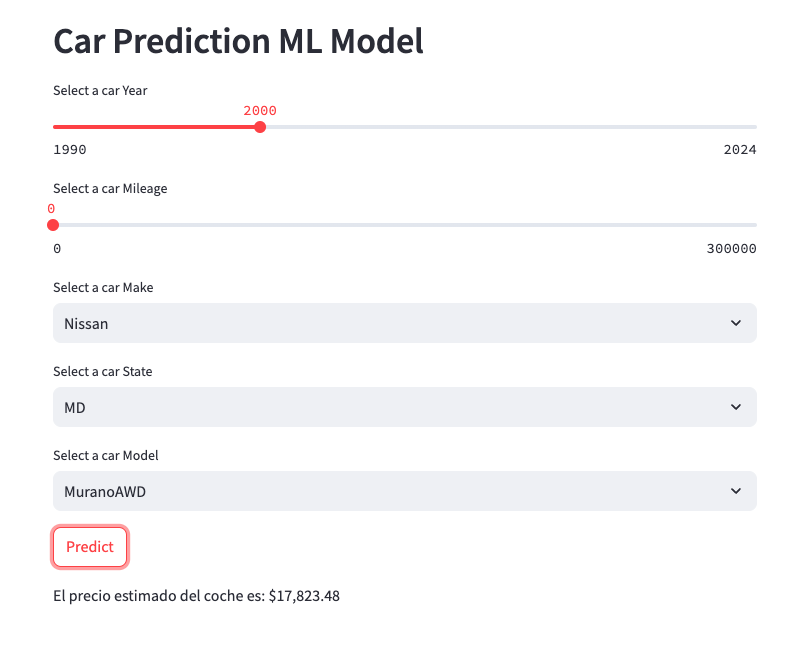

In [ ]:
!streamlit run app2.py


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8503
  Network URL: http://192.168.0.7:8503

^C
  Stopping...


## Pruebas de API

- Después de ver que la APP se había ejecuado de forma local se probó con Flask, pero no generaron el resultado esperado.

In [ ]:
loaded_model = joblib.load('model_rf.pkl')

In [ ]:
from flask import Flask, request, jsonify
import joblib
import pandas as pd

app = Flask(__name__)

# Cargar el modelo
model = joblib.load('model_rf.pkl')

@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Obtener los datos del cuerpo de la solicitud
        data = request.json

        # Convertir los datos a un DataFrame
        df2 = pd.DataFrame(data)

        # Hacer predicciones
        predictions = model.predict(df2)

        # Convertir las predicciones a una lista
        predictions_list = predictions.tolist()

        # Devolver las predicciones en formato JSON
        return jsonify(predictions=predictions_list)

    except Exception as e:
        return jsonify(error=str(e)), 400

if __name__ == '__main__':
    app.run(port=5000)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:7000
Press CTRL+C to quit
127.0.0.1 - - [06/Sep/2024 23:17:10] "GET / HTTP/1.1" 404 -
127.0.0.1 - - [06/Sep/2024 23:18:10] "GET / HTTP/1.1" 404 -
127.0.0.1 - - [06/Sep/2024 23:18:39] "GET / HTTP/1.1" 404 -


In [ ]:
from flask import Flask, request, jsonify
import joblib
import pandas as pd

app = Flask(__name__)

# Cargar el modelo
model = joblib.load('xgboost_model.pkl')
@app.route('/predict', methods=['POST'])
def predict():
    try:
        data = request.json
        df = pd.DataFrame(data)

        expected_columns = [
            'Year', 'Mileage', 'State_ CA', 'State_ CO', 'State_ FL',
            'State_ GA', 'State_ IL', 'State_ IN', 'State_ KY', 'State_ MA',
            'State_ MD', 'State_ MO', 'State_ NC', 'State_ NJ', 'State_ NY',
            'State_ OH', 'State_ PA', 'State_ TN', 'State_ TX', 'State_ VA',
            'State_ WA', 'State_Otros', 'Make_Buick', 'Make_Cadillac',
            'Make_Chevrolet', 'Make_Chrysler', 'Make_Dodge', 'Make_Ford',
            'Make_GMC', 'Make_Honda', 'Make_Hyundai', 'Make_Jeep', 'Make_Kia',
            'Make_Lexus', 'Make_MINI', 'Make_Mercedes-Benz', 'Make_Nissan',
            'Make_Otros', 'Make_Ram', 'Make_Subaru', 'Make_Toyota',
            'Make_Volkswagen', 'Model_Accord', 'Model_CamaroCoupe', 'Model_CamrySE',
            'Model_Civic', 'Model_CorollaLE', 'Model_EquinoxFWD', 'Model_F-1504WD',
            'Model_F-150XLT', 'Model_FusionSE', 'Model_Grand', 'Model_Jetta',
            'Model_MalibuLT', 'Model_Otros', 'Model_Ram', 'Model_Santa',
            'Model_Sierra', 'Model_Silverado', 'Model_Super', 'Model_Town',
            'Model_Wrangler'
        ]

        for col in expected_columns:
            if col not in df.columns:
                df[col] = 0

        df = df[expected_columns]

        # Hacer predicciones
        predictions = model.predict(df)
        # Convertir las predicciones a una lista
        predictions_list = predictions.tolist()
        # Devolver las predicciones en formato JSON
        return jsonify(predictions=predictions_list)

    except Exception as e:
        return jsonify(error=str(e)), 400

if __name__ == '__main__':
    app.run(port=5000)

In [ ]:
from flask import Flask, request, render_template, jsonify
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
import pickle

app = Flask(__name__)

# Carga el encoder preentrenado
with open('ordinal_encoder.pkl', 'rb') as f:
    ordinal_encoder = pickle.load(f)

# Carga los datos originales para la predicción (si es necesario)
data = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTrain_carListings.zip')

@app.route('/')
def home():
    # Renderiza un formulario HTML simple
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def predict():
    year = request.form.get('year')
    mileage = request.form.get('mileage')
    make = request.form.get('make')
    state = request.form.get('state')
    model = request.form.get('model')

    # Prepara los datos para la predicción
    Y_pred = pd.DataFrame([[year, mileage, make, state, model]], columns=['Year', 'Mileage', 'Make', 'State', 'Model'])

    # Asegura que las columnas estén en el orden correcto
    Y_pred = Y_pred[['State', 'Make', 'Model']]

    # Aplica la codificación
    Y_pred[['State', 'Make', 'Model']] = ordinal_encoder.transform(Y_pred[['State', 'Make', 'Model']])

    # Aquí podrías aplicar un modelo de predicción (ej: RandomForest, etc.)
    # Ejemplo de predicción ficticia
    prediction = 20000  # Por ejemplo, un valor predicho

    # Devuelve la predicción como respuesta JSON
    return jsonify({'prediction': prediction})

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:8000
 * Running on http://192.168.0.7:8000
Press CTRL+C to quit
127.0.0.1 - - [06/Sep/2024 23:31:27] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [06/Sep/2024 23:31:28] "GET /static/css/style.css HTTP/1.1" 304 -


In [ ]:
from flask import Flask, request, render_template, jsonify
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
import pickle

app = Flask(__name__)

# Carga el encoder preentrenado
with open('ordinal_encoder.pkl', 'rb') as f:
    ordinal_encoder = pickle.load(f)

# Carga los datos originales para la predicción (si es necesario)
data = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTrain_carListings.zip')

@app.route('/')
def home():
    # Renderiza un formulario HTML simple
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def predict():
    year = request.form.get('year')
    mileage = request.form.get('mileage')
    make = request.form.get('make')
    state = request.form.get('state')
    model = request.form.get('model')

    # Prepara los datos para la predicción
    Y_pred = pd.DataFrame([[year, mileage, make, state, model]], columns=['Year', 'Mileage', 'Make', 'State', 'Model'])

    # Asegura que las columnas estén en el orden correcto
    Y_pred = Y_pred[['State', 'Make', 'Model']]

    # Aplica la codificación
    Y_pred[['State', 'Make', 'Model']] = ordinal_encoder.transform(Y_pred[['State', 'Make', 'Model']])

    # Aquí podrías aplicar un modelo de predicción (ej: RandomForest, etc.)
    # Ejemplo de predicción ficticia
    prediction =  model.predict(Y_encoded)


    # Devuelve la predicción como respuesta JSON
    return jsonify({'prediction': prediction})

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (fsevents)
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/juanpablo.cuellar/Library/Python/3.11/lib/python/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/juanpablo.cuellar/Library/Python/3.11/lib/python/site-packages/traitlets/config/application.py", line 1074, in launch_instance
    app.initialize(argv)
  File "/Users/juanpablo.cuellar/Library/Python/3.11/lib/python/site-packages/traitlets/config/application.py", line 118, in inner
    return method(app, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/juanpablo.cuellar/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelapp.py", line 692, in initialize
    self.init_sockets()
  File "/Users/juanpablo.cuellar/Library/Python/3.11/lib/python/site-packages/ipyk

SystemExit: 1

/Users/juanpablo.cuellar/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
